In [13]:
# Cell 1 -- Install dependencies
!pip install ultralytics opencv-python pandas

In [14]:
# Cell 2: Clone the github repository to fetch the custom data
import os

repo_url = "https://github.com/nhahuynh/fridge-vision.git"
repo_name = "fridge-vision"

if not os.path.exists(repo_name):
    print(f"Cloning {repo_name}...")
    !git clone {repo_url}
else:
    print(f"Repository {repo_name} already exists.")

print(f"Files are located in: /content/{repo_name}")

Repository fridge-vision already exists.
Files are located in: /content/fridge-vision


In [15]:
# Cell 3 - Get the data ready
import os
import shutil
import pandas as pd
from pathlib import Path

# --- 1. Download the Data (Git Clone) ---
repo_url = "https://github.com/marcusklasson/GroceryStoreDataset.git"
repo_name = "GroceryStoreDataset"

if not os.path.exists(repo_name):
    print(f"Cloning {repo_name} from GitHub...")
    !git clone {repo_url}
else:
    print(f"{repo_name} already exists. Skipping download.")

# --- 2. Setup Paths ---
RAW_DATA_DIR = Path(f"./{repo_name}/dataset")
OUTPUT_DIR = Path("./yolo_grocery_dataset")

# --- 3. Conversion Logic ---
def convert_grocery_data():
    classes_file = RAW_DATA_DIR / "classes.csv"
    if not classes_file.exists():
        print("Error: classes.csv not found.")
        return

    # Load CSV
    df = pd.read_csv(classes_file)

    # Use the exact column names you found
    id_col = 'Class ID (int)'
    name_col = 'Class Name (str)'

    # Create map: ID -> Name
    class_map = dict(zip(df[id_col], df[name_col]))

    # Create directories
    for split in ['train', 'val', 'test']:
        (OUTPUT_DIR / 'images' / split).mkdir(parents=True, exist_ok=True)
        (OUTPUT_DIR / 'labels' / split).mkdir(parents=True, exist_ok=True)

    # Process text files
    for split in ['train', 'val', 'test']:
        txt_file = RAW_DATA_DIR / f"{split}.txt"
        if not txt_file.exists(): continue

        print(f"Converting {split} set...")
        with open(txt_file, 'r') as f:
            lines = f.readlines()

        for line in lines:
            # --- FIX: Handle commas in the text file ---
            # Replaces ',' with space so "0," becomes "0 "
            clean_line = line.replace(',', ' ')
            parts = clean_line.strip().split()

            if len(parts) < 2: continue

            rel_path = parts[0]
            # Now int() will work because the comma is gone
            class_id = int(parts[1])

            src_img_path = RAW_DATA_DIR / rel_path

            if src_img_path.exists():
                # Copy Image
                new_filename = f"{class_id}_{src_img_path.name}"
                dst_img = OUTPUT_DIR / 'images' / split / new_filename
                shutil.copy(src_img_path, dst_img)

                # Create Label
                dst_lbl = OUTPUT_DIR / 'labels' / split / f"{Path(new_filename).stem}.txt"
                with open(dst_lbl, 'w') as lf:
                    lf.write(f"{class_id} 0.5 0.5 1.0 1.0\n")

    print(f"\nData ready at: {OUTPUT_DIR}")

    # Generate YAML
    sorted_names = [class_map[i] for i in sorted(class_map.keys())]

    yaml_content = f"""
path: {OUTPUT_DIR.absolute()}
train: images/train
val: images/val
test: images/test

nc: {len(sorted_names)}
names: {sorted_names}
"""
    with open('grocery_data.yaml', 'w') as f:
        f.write(yaml_content)
    print("Config file 'grocery_data.yaml' updated successfully.")

if __name__ == "__main__":
    convert_grocery_data()

GroceryStoreDataset already exists. Skipping download.
Converting train set...
Converting val set...
Converting test set...

Data ready at: yolo_grocery_dataset
Config file 'grocery_data.yaml' updated successfully.


In [16]:
# Cell 4: Ingest MANUAL Uploads (images in New_Training_Data folder)
import os
import shutil
import pandas as pd
from pathlib import Path

# Config for MANUAL uploads
STAGING_DIR = Path("new_training_data")
DATASET_DIR = Path("./yolo_grocery_dataset")
CLASSES_FILE = Path("./GroceryStoreDataset/dataset/classes.csv")

def ingest_manual_data():
    if not CLASSES_FILE.exists(): return

    # Load Class Map
    df = pd.read_csv(CLASSES_FILE)
    name_col = 'Class Name (str)'
    id_col = 'Class ID (int)'
    name_to_id = dict(zip(df[name_col], df[id_col]))

    if not STAGING_DIR.exists():
        print(f"No manual upload folder found at {STAGING_DIR}. Skipping.")
        return

    print(f"Scanning manual uploads in: {STAGING_DIR}...")
    added_count = 0

    for folder in STAGING_DIR.iterdir():
        if not folder.is_dir(): continue

        class_name = folder.name
        if class_name in name_to_id:
            class_id = name_to_id[class_name]

            for img_file in folder.iterdir():
                if img_file.suffix.lower() in ['.jpg', '.jpeg', '.png']:
                    # Use 'manual_' prefix to distinguish these files
                    new_filename = f"manual_{class_id}_{img_file.name}"
                    dst_img = DATASET_DIR / 'images' / 'train' / new_filename
                    shutil.copy(img_file, dst_img)

                    dst_lbl = DATASET_DIR / 'labels' / 'train' / f"{dst_img.stem}.txt"
                    with open(dst_lbl, 'w') as f:
                        f.write(f"{class_id} 0.5 0.5 1.0 1.0\n")
                    added_count += 1

    print(f"✅ Added {added_count} manual images from New_Training_Data.")

ingest_manual_data()

No manual upload folder found at new_training_data. Skipping.


In [17]:
#Cell 5 - Get classes from GroceryStoreDataset to write yaml file

# Fix config
import pandas as pd
from pathlib import Path

# 1. Locate the source of truth (classes.csv)
csv_path = Path("./GroceryStoreDataset/dataset/classes.csv")

if csv_path.exists():
    # 2. Read the class list
    df = pd.read_csv(csv_path)

    # Clean column names (remove hidden spaces)
    df.columns = df.columns.str.strip()

    # Identify correct columns
    id_col = 'Class ID (int)'
    name_col = 'Class Name (str)'

    # Create the sorted list of names (Index 0 to 80)
    # We sort by ID to ensure the model maps ID 0 to the first name, ID 1 to the second, etc.
    sorted_df = df.sort_values(by=id_col)
    class_names = sorted_df[name_col].tolist()

    # 3. Write the correct YAML file
    yaml_content = f"""
path: {Path('./yolo_grocery_dataset').absolute()}
train: images/train
val: images/val
test: images/test

nc: {len(class_names)}
names: {class_names}
"""

    with open('grocery_data.yaml', 'w') as f:
        f.write(yaml_content)

    print(f"✅ Fixed! generated 'grocery_data.yaml' with:")
    print(f"   - nc: {len(class_names)}")
    print(f"   - names length: {len(class_names)}")
else:
    print("❌ Error: Could not find classes.csv. Please re-run the dataset download step (Cell 3).")

✅ Fixed! generated 'grocery_data.yaml' with:
   - nc: 81
   - names length: 81


In [18]:
# Cell 6: Ingest images from the cloned repo into the Training Set
import os
import shutil
import pandas as pd
from pathlib import Path

# --- CONFIGURATION ---
SOURCE_PATH = Path("./fridge-vision/data")
DATASET_DIR = Path("./yolo_grocery_dataset")
CLASSES_FILE = Path("./GroceryStoreDataset/dataset/classes.csv")

def ingest_repo_data():
    if not CLASSES_FILE.exists():
        print("Error: classes.csv not found. Please run the setup cells.")
        return

    # 1. Load Class Map
    df = pd.read_csv(CLASSES_FILE)
    name_col = 'Class Name (str)'
    id_col = 'Class ID (int)'
    name_to_id = dict(zip(df[name_col], df[id_col]))

    # 2. Walk through the repo folders
    if not SOURCE_PATH.exists():
        print(f"Error: Could not find source path: {SOURCE_PATH}")
        return

    print(f"Scanning for labeled folders in: {SOURCE_PATH}...")
    added_count = 0

    # Look for folders that match class names (e.g. 'Golden-Delicious', 'Milk')
    # Use os.walk to find nested folders
    for root, dirs, files in os.walk(SOURCE_PATH):
        for folder_name in dirs:
            # Check if this folder name matches a known class
            if folder_name in name_to_id:
                class_id = name_to_id[folder_name]
                folder_path = Path(root) / folder_name

                # Copy all images from this folder
                for img_file in folder_path.iterdir():
                    if img_file.suffix.lower() in ['.jpg', '.jpeg', '.png']:

                        # Create unique filename to avoid overwriting
                        new_filename = f"repo_{class_id}_{img_file.name}"
                        dst_img = DATASET_DIR / 'images' / 'train' / new_filename

                        # Copy Image
                        shutil.copy(img_file, dst_img)

                        # Create Label
                        dst_lbl = DATASET_DIR / 'labels' / 'train' / f"{dst_img.stem}.txt"
                        with open(dst_lbl, 'w') as f:
                            f.write(f"{class_id} 0.5 0.5 1.0 1.0\n")

                        added_count += 1

    if added_count == 0:
        print("Warning: No matching folder names found. Make sure folders in the repo are named EXACTLY like the classes (e.g. 'Golden-Delicious').")
    else:
        print(f"\n✅ Success! Added {added_count} images from repo to the training set.")

ingest_repo_data()

Scanning for labeled folders in: fridge-vision/data...

✅ Success! Added 6 images from repo to the training set.


In [19]:

# Cell 7: TRAIN THE MODEL
from ultralytics import YOLO

model = YOLO('yolov8s.pt')

print("Starting training...")

results = model.train(
    data='grocery_data.yaml',
    epochs=10,
    imgsz=640,
    batch=16,
    patience=10,
    augment=True,
    name='fridge_model_smart'   # location where results are saved
)

print("Training finished!")

Starting training...
Ultralytics 8.3.236 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=grocery_data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=fridge_model_smart3, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=10, perspective=0

In [20]:
# Cell 10: Generate Ground Truth Labels (With Smart Filename Matching)
import os
import pandas as pd
from pathlib import Path

# --- CONFIGURATION ---
repo_name = "fridge-vision"
TEST_IMAGES_DIR = Path(f"/content/{repo_name}/data/Test_images")
CLASSES_FILE = Path("./GroceryStoreDataset/dataset/classes.csv")

def generate_smart_keys():
    if not CLASSES_FILE.exists():
        print("❌ Error: classes.csv not found.")
        return

    # 1. Load and Prepare the Lookup Dictionary
    df = pd.read_csv(CLASSES_FILE)

    # Clean up column names
    df.columns = df.columns.str.strip()

    # We need a robust dictionary that maps ANY name (Fine or Coarse) to a valid YOLO Class ID
    # Priority 1: Fine Class Name -> Class ID (e.g. "Golden-Delicious" -> 0)
    name_to_id = dict(zip(df['Class Name (str)'], df['Class ID (int)']))

    # Priority 2: Coarse Class Name -> First available Class ID for that group
    # (e.g. Map "Apple" to 0, "Milk" to 24)
    # We iterate through the DF so the first time 'Apple' appears, we save that ID
    coarse_to_id = {}
    for index, row in df.iterrows():
        coarse_name = row['Coarse Class Name (str)']
        fine_id = row['Class ID (int)']
        if coarse_name not in coarse_to_id:
            coarse_to_id[coarse_name] = fine_id

    # Combine them into one master lookup (Fine names overwrite Coarse if duplicates exist)
    master_lookup = {**coarse_to_id, **name_to_id}

    # Sort keys by length (descending) so we match "Pineapple" before "Apple"
    sorted_keys = sorted(master_lookup.keys(), key=len, reverse=True)

    print(f"Scanning images in: {TEST_IMAGES_DIR}...")
    created_count = 0
    skipped_count = 0

    # 2. Walk through every FILE (not just folders)
    for root, dirs, files in os.walk(TEST_IMAGES_DIR):
        for filename in files:
            if filename.lower().endswith(('.jpg', '.jpeg', '.png')):

                image_path = Path(root) / filename
                folder_name = Path(root).name

                # --- MATCHING LOGIC ---
                class_id = None

                # Attempt A: Check Folder Name (Exact Match)
                if folder_name in master_lookup:
                    class_id = master_lookup[folder_name]

                # Attempt B: Check Filename (Smart Match)
                # If folder failed, check if filename starts with a known class
                if class_id is None:
                    # We check the longest names first to avoid "Pineapple" matching "Apple"
                    for key in sorted_keys:
                        # Case-insensitive check
                        if filename.lower().startswith(key.lower()):
                            class_id = master_lookup[key]
                            # print(f"   found match: {filename} -> {key} (ID {class_id})")
                            break

                # --- RESULT ---
                if class_id is not None:
                    # Create the .txt file
                    label_path = image_path.with_suffix(".txt")
                    with open(label_path, 'w') as f:
                        f.write(f"{class_id} 0.5 0.5 1.0 1.0\n")
                    created_count += 1
                else:
                    # Only print warning if we haven't warned about this folder before
                    # (To avoid spamming the console)
                    skipped_count += 1

    print(f"\n✅ Success! Created {created_count} answer keys.")
    if skipped_count > 0:
        print(f"⚠️ Skipped {skipped_count} images (could not match filename to any class).")
        print("   Tip: Rename files to start with the class name (e.g., 'Apple_01.jpg')")

generate_smart_keys()

Scanning images in: /content/fridge-vision/data/Test_images...

✅ Success! Created 11 answer keys.
⚠️ Skipped 3 images (could not match filename to any class).
   Tip: Rename files to start with the class name (e.g., 'Apple_01.jpg')


🔄 Updating repository to get latest images...
Cloning into 'fridge-vision'...
remote: Enumerating objects: 217, done.
remote: Counting objects: 100% (51/51), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 217 (delta 28), reused 15 (delta 15), pack-reused 166 (from 1)
Receiving objects: 100% (217/217), 7.81 MiB | 15.15 MiB/s, done.
Resolving deltas: 100% (75/75), done.
✅ Repository updated successfully!
⚠️ No trained weights found. Using pretrained yolov8n.pt instead.
Running YOLO detection on images in: /content/fridge-vision/data/Test_images

image 1/14 /content/fridge-vision/data/Test_images/Apple.png: 640x480 1 person, 3 apples, 7.3ms
image 2/14 /content/fridge-vision/data/Test_images/Apple_1.png: 448x640 7 apples, 8.9ms
image 3/14 /content/fridge-vision/data/Test_images/Apple_2.png: 448x640 7 apples, 6.1ms
image 4/14 /content/fridge-vision/data/Test_images/Bravo Orange juice.png: 640x640 1 person, 1 bottle, 1 book, 8.4ms
image 5/14 /content/fridge-vision/data/

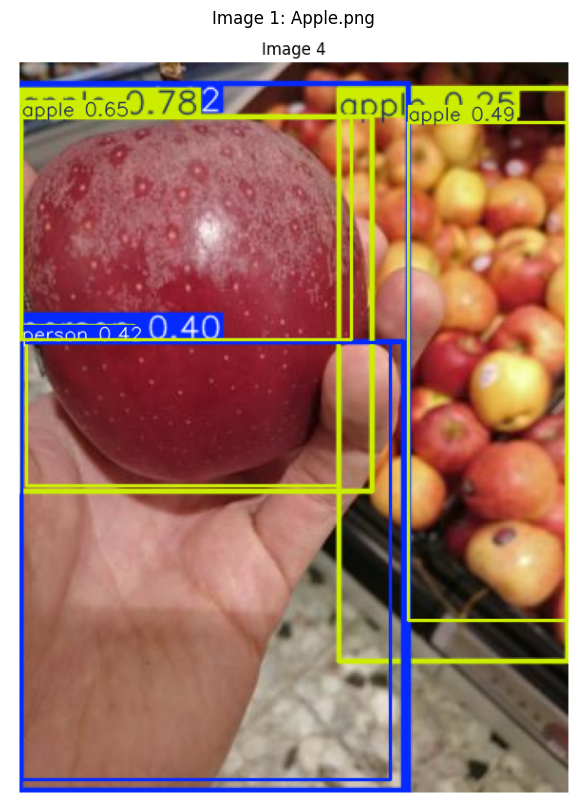

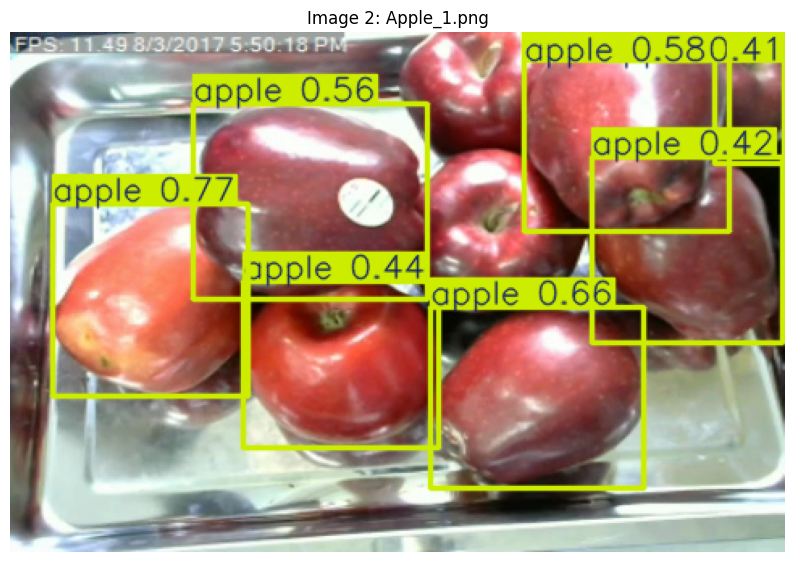

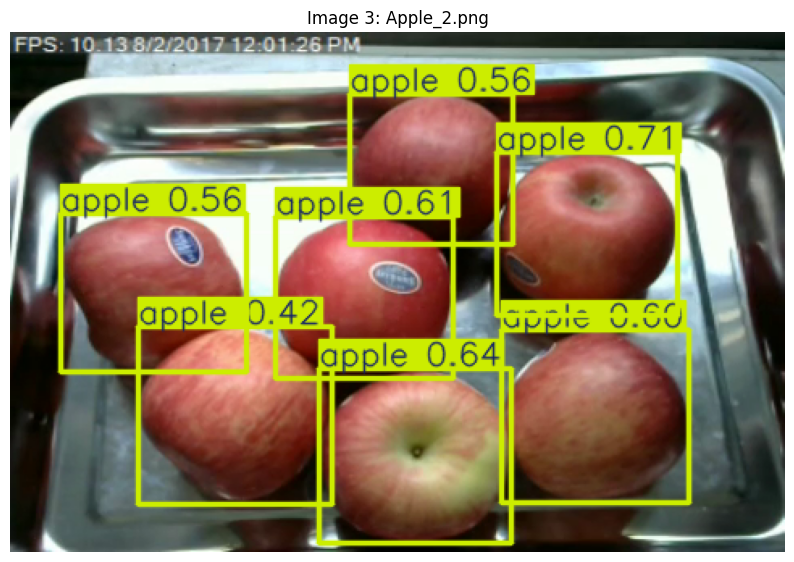

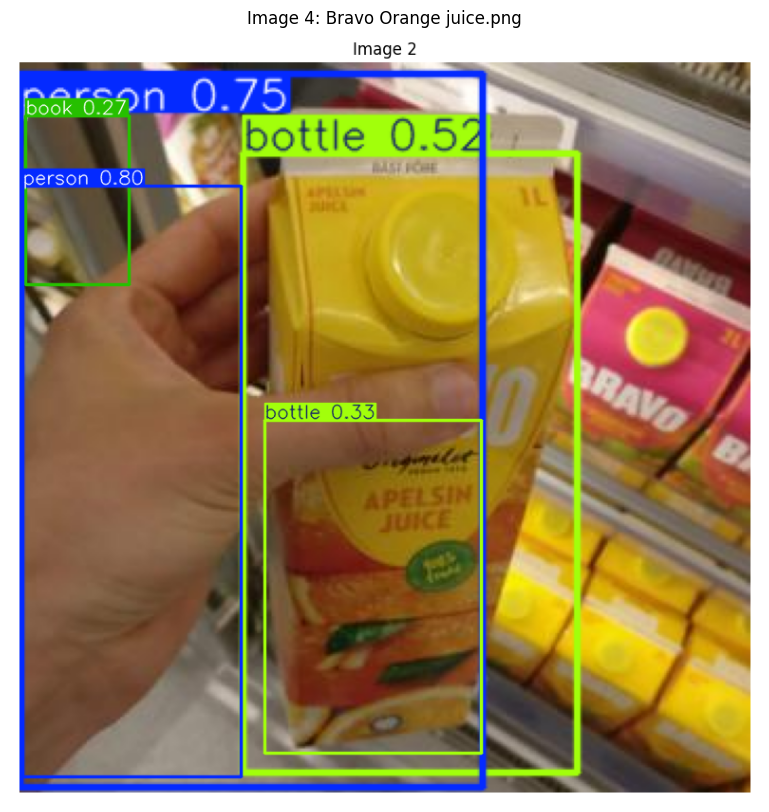

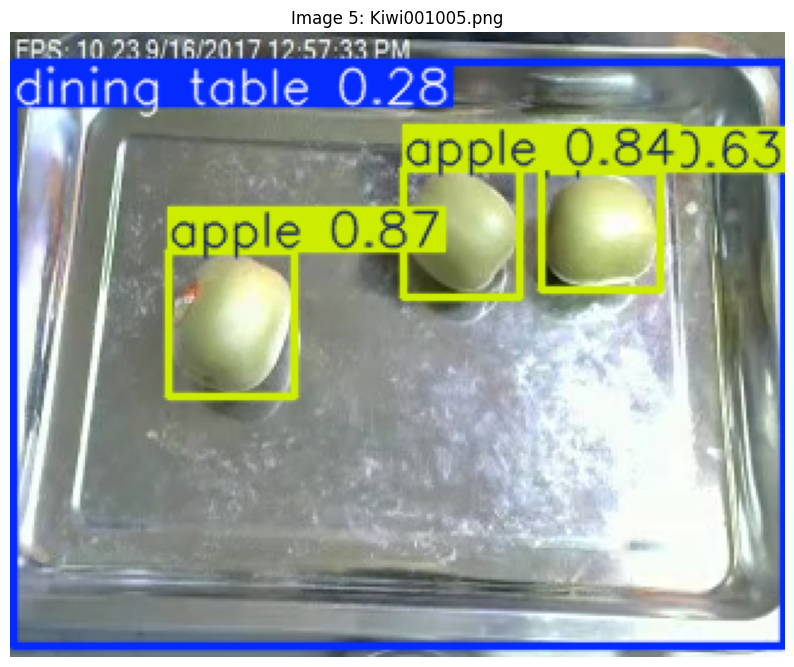

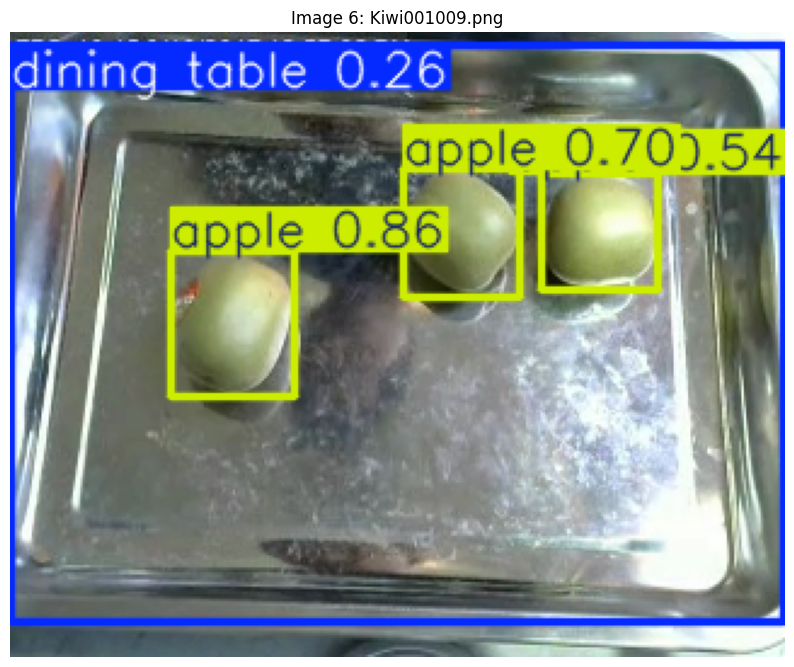

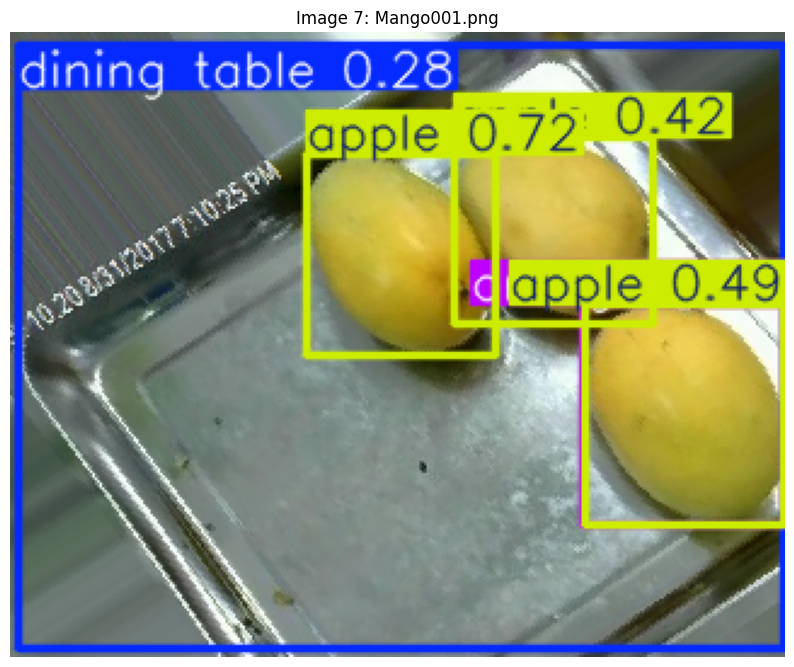

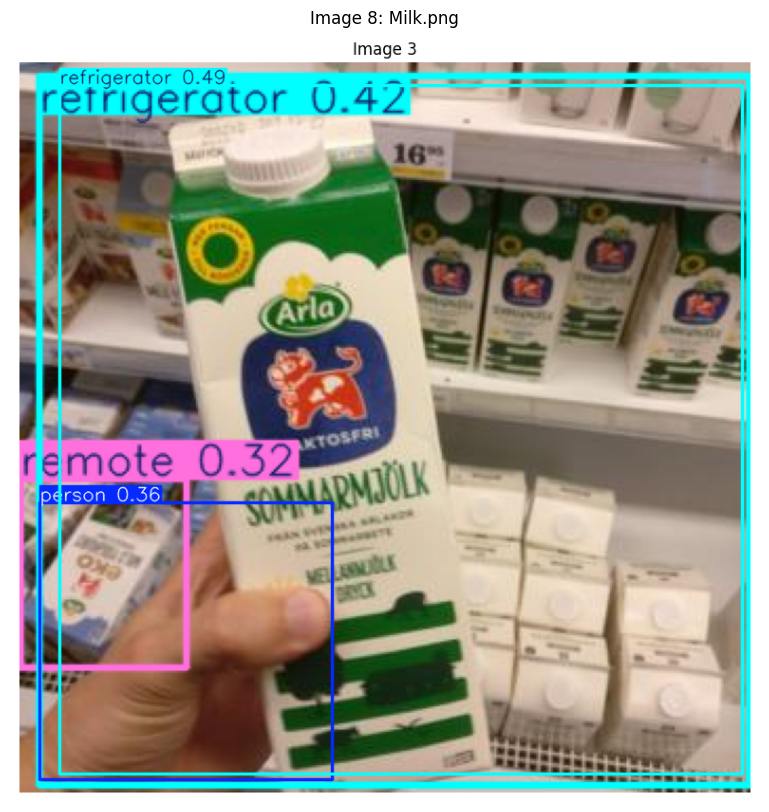

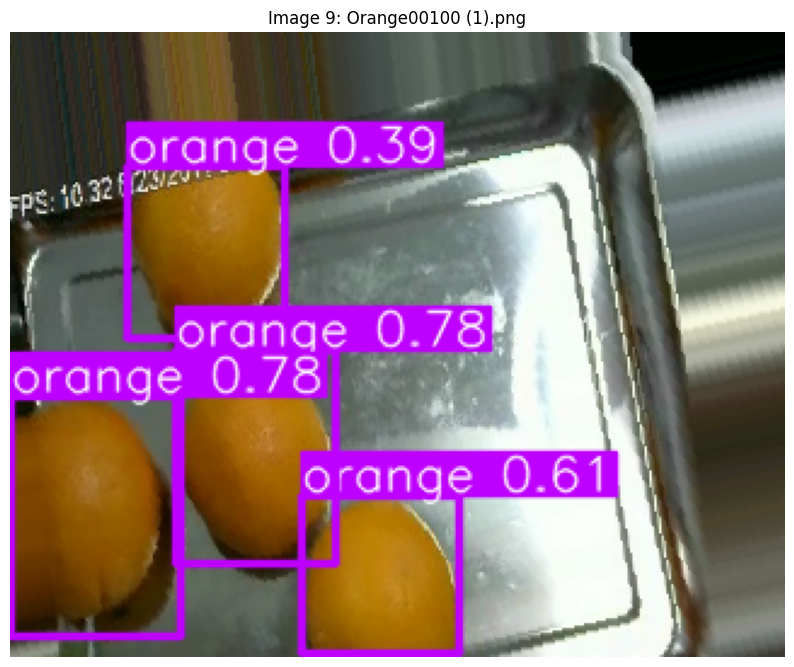

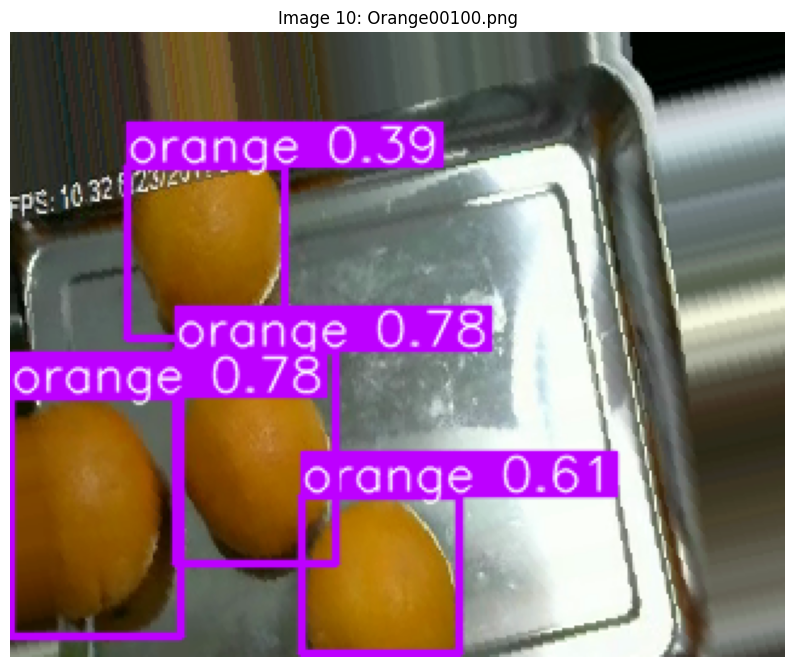

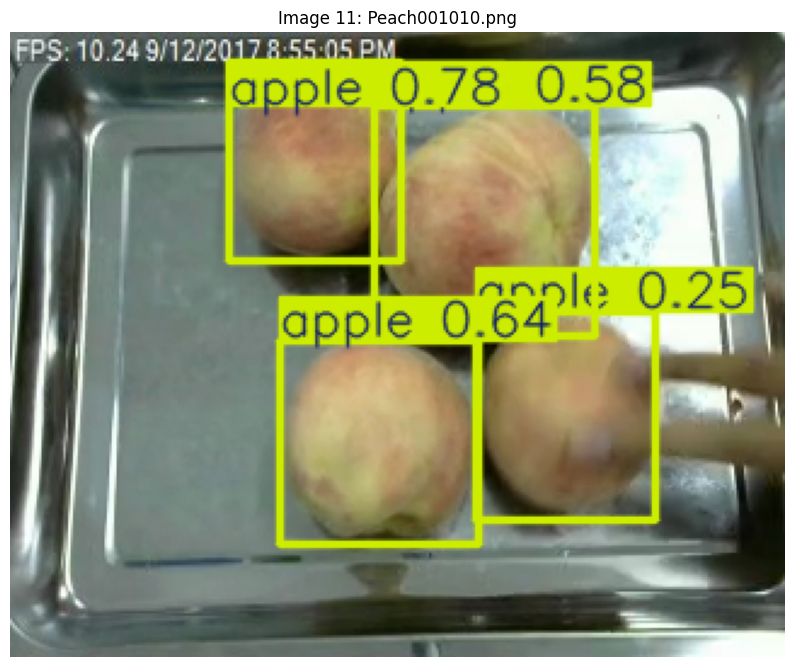

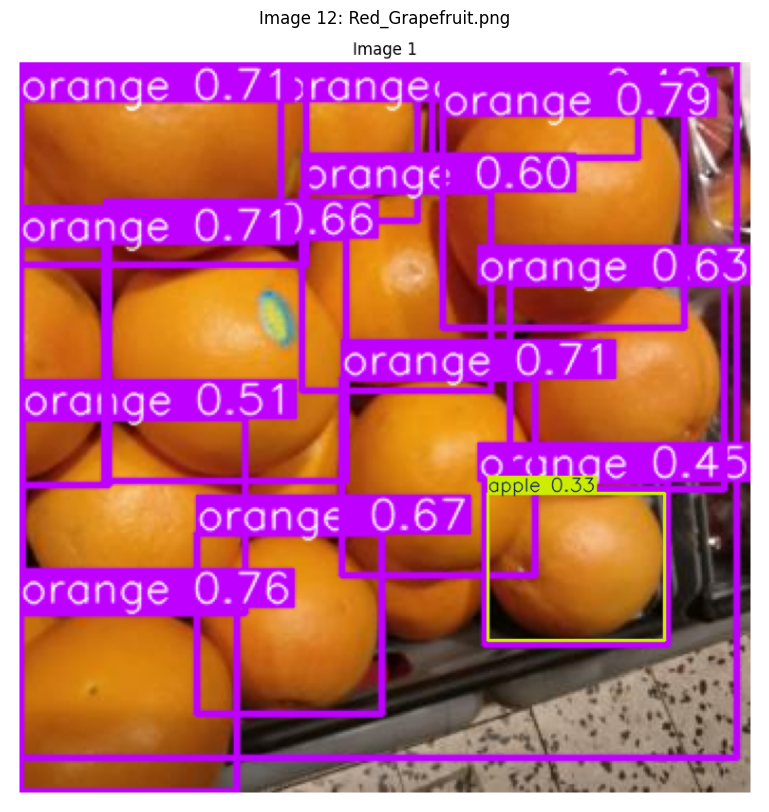

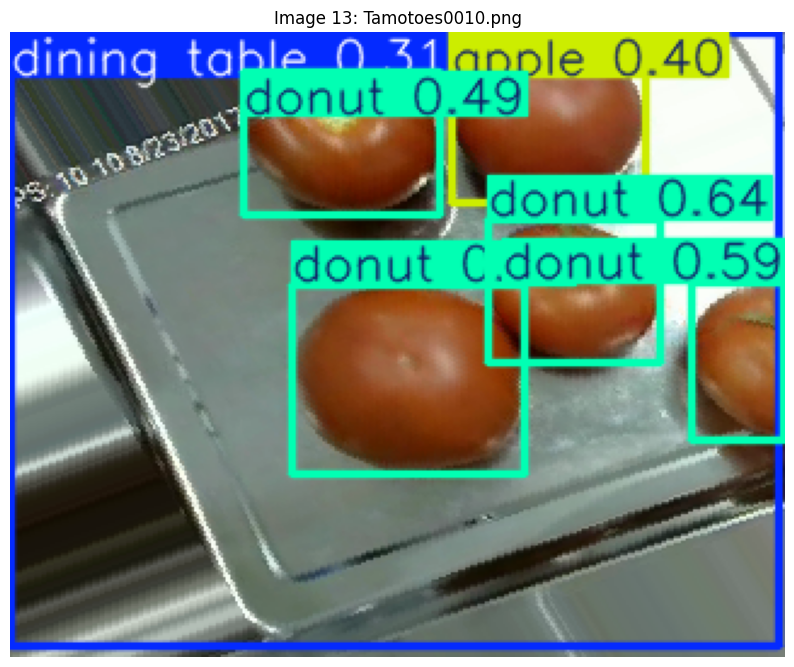

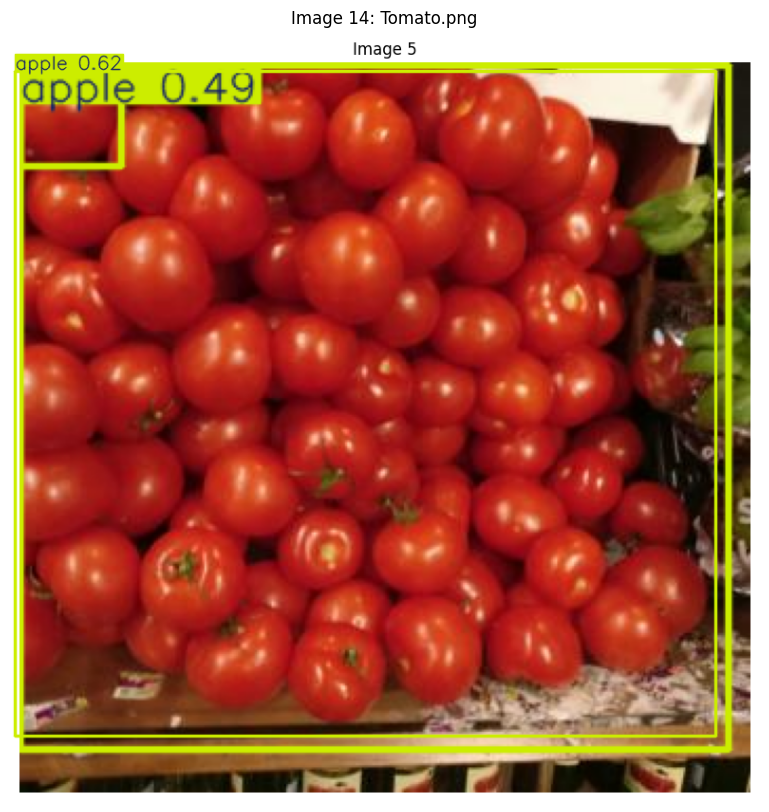

In [21]:
# Cell 9 - Running prediction on images from the new Repo (Auto-Updated)

# 1. Install ultralytics
!pip install ultralytics --quiet

from ultralytics import YOLO
import os
import shutil
import matplotlib.pyplot as plt
from pathlib import Path

# --- Fetch the repo again in case new manual training images were uploaded ---
repo_name = "fridge-vision"
repo_url = "https://github.com/nhahuynh/fridge-vision.git"
local_path = f"/content/{repo_name}"

print("🔄 Updating repository to get latest images...")
if os.path.exists(local_path):
    # Delete the old folder to avoid conflicts
    shutil.rmtree(local_path)

# Download the fresh copy
!git clone {repo_url}
print("✅ Repository updated successfully!")
# ------------------------------------------

# 2. Load the model
# NOTE: Using the path to the best weights
trained_weights = "runs/detect/train/weights/best.pt"

if os.path.exists(trained_weights):
    print(f"Using trained model: {trained_weights}")
    model = YOLO(trained_weights)
else:
    # Fallback checks
    alt_weights = "runs/detect/fridge_model_repo_update/weights/best.pt"
    if os.path.exists(alt_weights):
        print(f"Found specific run. Using: {alt_weights}")
        model = YOLO(alt_weights)
    else:
        print("⚠️ No trained weights found. Using pretrained yolov8n.pt instead.")
        model = YOLO("yolov8n.pt")

TEST_IMAGES_DIR = f"/content/{repo_name}/data/Test_images"

if not os.path.exists(TEST_IMAGES_DIR):
    # Try lowercase just in case
    TEST_IMAGES_DIR = f"/content/{repo_name}/data/test_images"

print(f"Running YOLO detection on images in: {TEST_IMAGES_DIR}")

# 4. Run YOLO
results = model.predict(
    source=TEST_IMAGES_DIR,
    save=True,
    imgsz=640
)

print("\n" + "="*40)
print("PREDICTION RESULTS")
print("="*40)

# 5. Display images inline
for i, r in enumerate(results):
    img_bgr = r.plot()
    img_rgb = img_bgr[..., ::-1]

    plt.figure(figsize=(10, 10))
    plt.imshow(img_rgb)
    plt.title(f"Image {i+1}: {Path(r.path).name}")
    plt.axis('off')
    plt.show()

In [23]:
# Cell 10: Automatic Accuracy Calculation
from ultralytics import YOLO

# Load model
model = YOLO("runs/detect/fridge_model_smart3/weights/best.pt") # Corrected path

print("Running automatic validation...")

# We use mode='val' to compare predictions vs answer keys
metrics = model.val(
    data='grocery_data.yaml',  # Uses the config to know class names
    split='test',              # Tells it to use the test set
    save_json=True
)

print("\n" + "="*30)
print("🏆 AUTOMATED RESULTS")
print("="*30)
# mAP50 is a common accuracy metric for Object Detection
print(f"Mean Average Precision (mAP@50): {metrics.box.map50:.2%}")
print(f"Precision: {metrics.box.mp:.2%}")
print(f"Recall:    {metrics.box.mr:.2%}")
print("="*30)

Running automatic validation...
Ultralytics 8.3.236 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,156,931 parameters, 0 gradients, 28.6 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1050.4±383.4 MB/s, size: 23.8 KB)
val: Scanning /content/yolo_grocery_dataset/labels/test... 2485 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 2485/2485 2.3Kit/s 1.1s
val: New cache created: /content/yolo_grocery_dataset/labels/test.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 156/156 4.3it/s 36.3s
                   all       2485       2485      0.784      0.789      0.832      0.832
      Golden-Delicious         45         45      0.398        0.6       0.41       0.41
          Granny-Smith         58         58      0.398      0.828      0.592      0.592
             Pink-Lady         59         59      0.799      0.932      0.932      0.932
         Red-Deliciou